In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm_notebook
import numpy as np
import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        plt.tight_layout()
    return

In [91]:
def optimizeSARIMA(data, parameters_list, d, D, s):    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [149]:
def plotSARIMA(series, model, s, d, n_steps):
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN
    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    # forecast.index = forecast.index.to_timestamp(freq='D')
    # forecast.index = pd.DatetimeIndex(forecast.index).to_period('D')
    plt.plot(forecast, color='r', label="model")
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

# Реальный ряд

Для примера взяты реальные данные цен акций компании Apple.

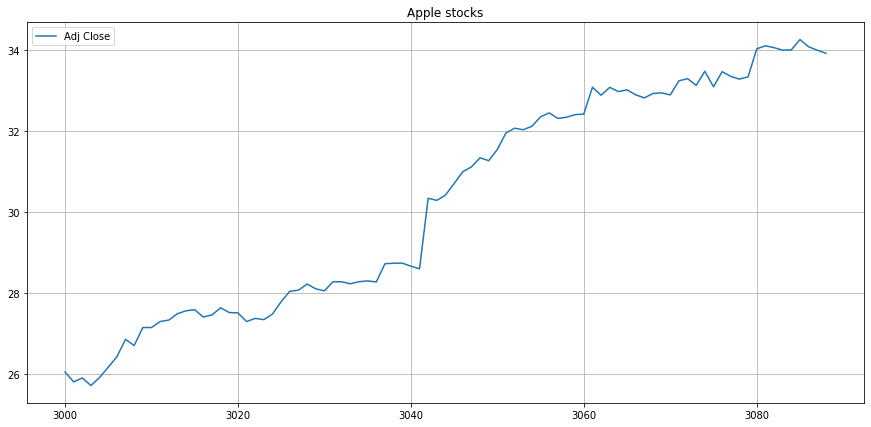

In [136]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AAPL.csv', parse_dates=['Date'])
dataset = dataset[3000:]
data = dataset.loc[:, 'Adj Close']
data = data.to_frame()
# dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AAPL.csv', parse_dates=['Date'], dayfirst=True)
# dataset = dataset[3000:]
# data = dataset.copy()
# data['Time'] = data.Date.dt.time
# data['Date'] = data['Date'].astype(str) + ' ' + data['Time'].astype(str)
# data = data.set_index('Date')
# data = data.loc[:, 'Adj Close']
# data = data.to_frame()
# data.index = pd.DatetimeIndex(data.index).to_period('D')
data.plot(figsize=(15, 7), title='Apple stocks', grid=True)

In [45]:
dataset.shape

(89, 7)

In [137]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
3000,2016-11-30,27.900000,28.049999,27.567499,27.629999,26.045576,144649200
3001,2016-12-01,27.592501,27.735001,27.257500,27.372499,25.802837,148347600
3002,2016-12-02,27.292500,27.522499,27.212500,27.475000,25.899462,106112000
3003,2016-12-05,27.500000,27.507500,27.062500,27.277500,25.713289,137298000
3004,2016-12-06,27.375000,27.590000,27.297501,27.487499,25.911245,104782000


In [148]:
data.tail()

,Adj Close
3084,34.011723
3085,34.264977
3086,34.087471
3087,34.002262
3088,33.926510


In [13]:
type(data)

pandas.core.frame.DataFrame

Для проверки на стационарность проведем тест Дикки-Фуллера:

In [139]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['Adj Close'])[1])

Критерий Дики-Фуллера: p=0.834573


Проведенный тест подтвердил предположения о не стационарности ряда. Во многих случаях взятие разности рядов позволяет это сделать. Возьмем первые разности.

In [140]:
data_diff = data.diff(periods=1).dropna()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_diff['Adj Close'])[1])

Критерий Дики-Фуллера: p=0.000000


Тест Дикки-Фуллера показывает стационарность.

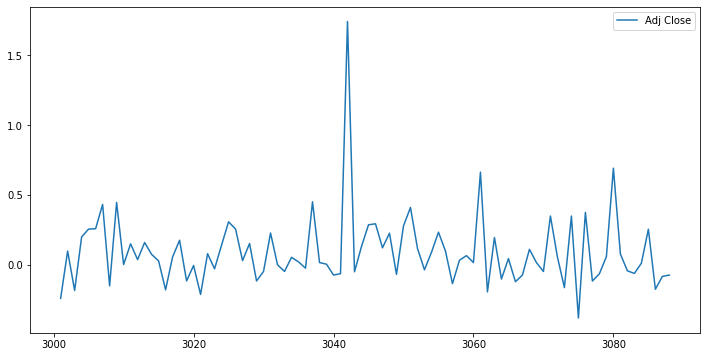

In [141]:
data_diff.plot(figsize=(12,6))

Изучим автокорреляционную(ACF) и частично автокорреляционную(PACF) функции для получившегося ряда.

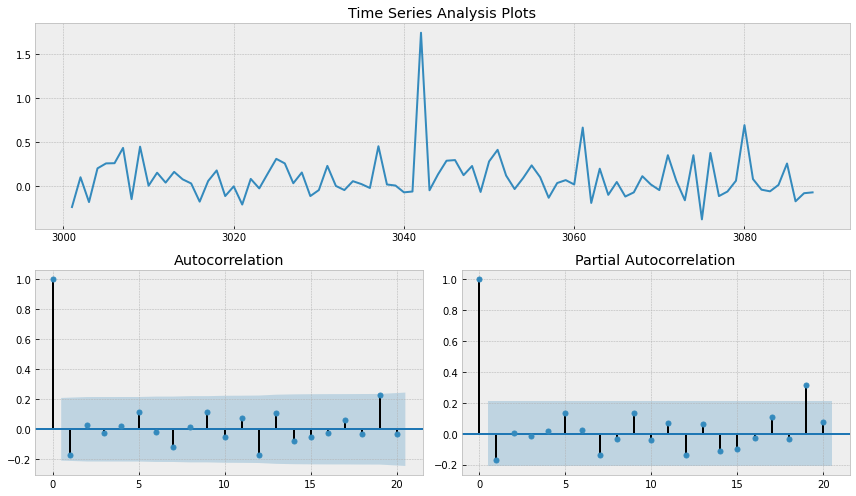

In [142]:
tsplot(data_diff['Adj Close'])

Введем начальные значения параметров модели ARIMA

In [104]:
ps = range(1, 20)
d=1
qs = range(1, 20)
Ps = range(0, 2)
D=0
Qs = range(0, 2)
s=1

# creating list with all the possible combinations of parameters
parameters = itertools.product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

361

Найдем оптимальные значения параметров, минимизирующие AIC модели.

In [105]:
result_table = optimizeSARIMA(data['Adj Close'], parameters_list, d, D, s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/361 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimiza

In [106]:
result_table.head()

,parameters,aic
0,"(2, 1)",23.108705
1,"(1, 2)",23.137333
2,"(1, 1)",23.384322
3,"(3, 3)",24.421912
4,"(2, 2)",25.105722


Строим ARIMA модель с оптимальными параметрами.

In [143]:
p, q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data['Adj Close'], order=(p, d, q)).fit(disp=-1)
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   89
Model:               SARIMAX(2, 1, 1)   Log Likelihood                  -7.554
Date:                Sat, 29 Jan 2022   AIC                             23.109
Time:                        18:16:25   BIC                             33.018
Sample:                             0   HQIC                            27.101
                                 - 89                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8135      0.186      4.367      0.000       0.448       1.179
ar.L2          0.1759      0.180      0.976      0.329      -0.177       0.529
ma.L1         -0.9488      0.088    -10.744      0.0

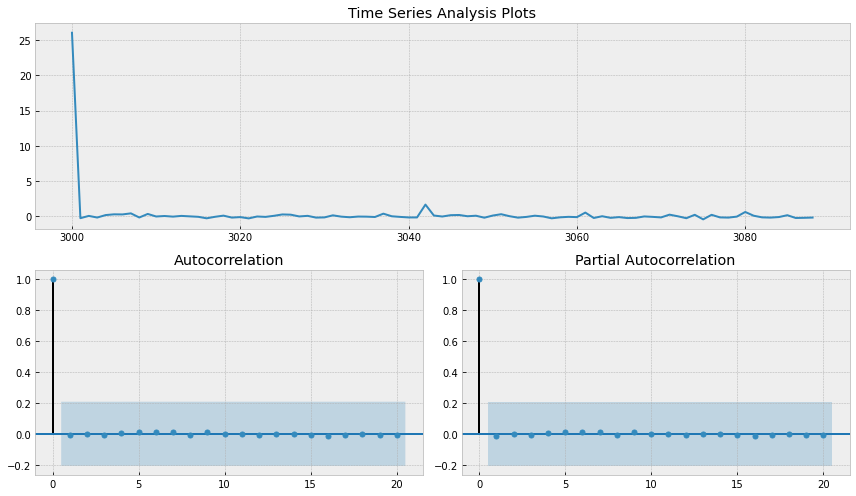

In [144]:
tsplot(best_model.resid)

Видно, что остатки стационарны и явных автокорреляций нет. Теперь можно делать прогнозы, используя нашу модель.

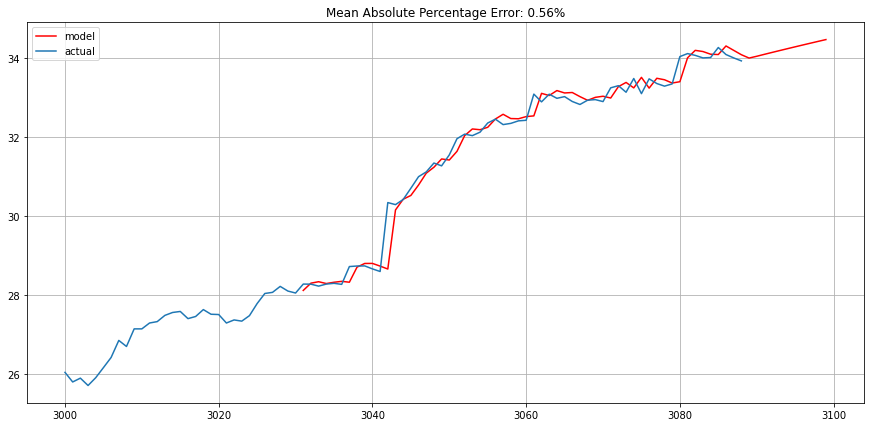

In [150]:
plotSARIMA(data, best_model, 30, 1, 10)